# Comparative Subject VAE

In [1]:
# !pip install torchinfo
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import os
import gc
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np
import time
import CompMethods_V3 as TP
import DataSetting_v5 as DS

In [2]:
date = '20240917'
name = f'{date}_COMP_sub'
data_path = ['../dataset/Door_EXP/A208']
level = 'subject'

data_organizer = DS.DataOrganizer(name, data_path, level)
data_organizer.load()

Cross validation plan at subject level
Loading ../dataset/Door_EXP/A208...

Loaded 0709A23-csi.npy of shape (111248, 30, 3)
Loaded 0709A41-csi.npy of shape (248817, 30, 3)
Loaded 0709A24-csi.npy of shape (38347, 30, 3)
Loaded 0709A20-csi.npy of shape (209993, 30, 3)
Loaded 0709A14-csi.npy of shape (168611, 30, 3)
Loaded 0709A12-csi.npy of shape (151822, 30, 3)
Loaded 0709A02-csi.npy of shape (232687, 30, 3)
Loaded 0709A11-csi.npy of shape (219643, 30, 3)
Loaded 0709A50-csi.npy of shape (133412, 30, 3)
Loaded 0709A511-csi.npy of shape (62914, 30, 3)
Loaded 20240709_153519-rimg.npy of shape (4057, 128, 226)
Loaded 20240709_154950-rimg.npy of shape (6302, 128, 226)
Loaded 20240709_161802-rimg.npy of shape (3442, 128, 226)
Loaded 20240709_185105-rimg.npy of shape (6481, 128, 226)
Loaded 20240709_192745-rimg.npy of shape (7787, 128, 226)
Loaded 20240709_193501-rimg.npy of shape (3267, 128, 226)
Loaded 20240709_191754-rimg.npy of shape (5395, 128, 226)
Loaded 20240709_163045-rimg.npy of shap

### VAE

In [3]:
preprocess = DS.Preprocess(new_size=(128, 128))
data_organizer.load_plan('../dataset/Door_EXP/subject_r0.2.pkl')

def run():
    for i in range(6):
        data_organizer.gen_plan()
        train_loader, valid_loader, test_loader, current_test = data_organizer.gen_loaders(mode='s', num_workers=0)
        if current_test in ('higashinaka', 'jiao'):
            continue
        VAE_trainer = TP.CompTrainer(name='VAE', mode='vae', mask=False,
                                     networks=[TP.CSIEncoder(mode='vae', middle_dim=512*7*75, latent_dim=128), 
                                               TP.ImageDecoder(latent_dim=128)],
                                     lr=1e-4, epochs=10, cuda=gpu,
                                     preprocess = preprocess,
                                     loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]},
                                     notion=f"{name}_{current_test}_VAE",
                                     train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)
        vae_trained = VAE_trainer.schedule(early_stop=True, lr_decay=True)
        break

Loaded plan!


Generating loaders for s: level = subject, current test = higashinaka
 Train dataset length = 9503
 Test dataset length = 2027
 Exported train loader of len 118, batch size = 64
 Exported valid loader of len 29, batch size = 64
 Exported test loader of len 32, batch size = 1

Generating loaders for s: level = subject, current test = jiao
 Train dataset length = 8297
 Test dataset length = 3231
 Exported train loader of len 103, batch size = 64
 Exported valid loader of len 25, batch size = 64
 Exported test loader of len 51, batch size = 1

Generating loaders for s: level = subject, current test = zhang
 Train dataset length = 9786
 Test dataset length = 1740
 Exported train loader of len 122, batch size = 64
 Exported valid loader of len 30, batch size = 64
 Exported test loader of len 28, batch size = 1

==========20240917_COMP_sub_zhang_VAE VAE Training starting==========


  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

<Figure size 432x288 with 0 Axes>

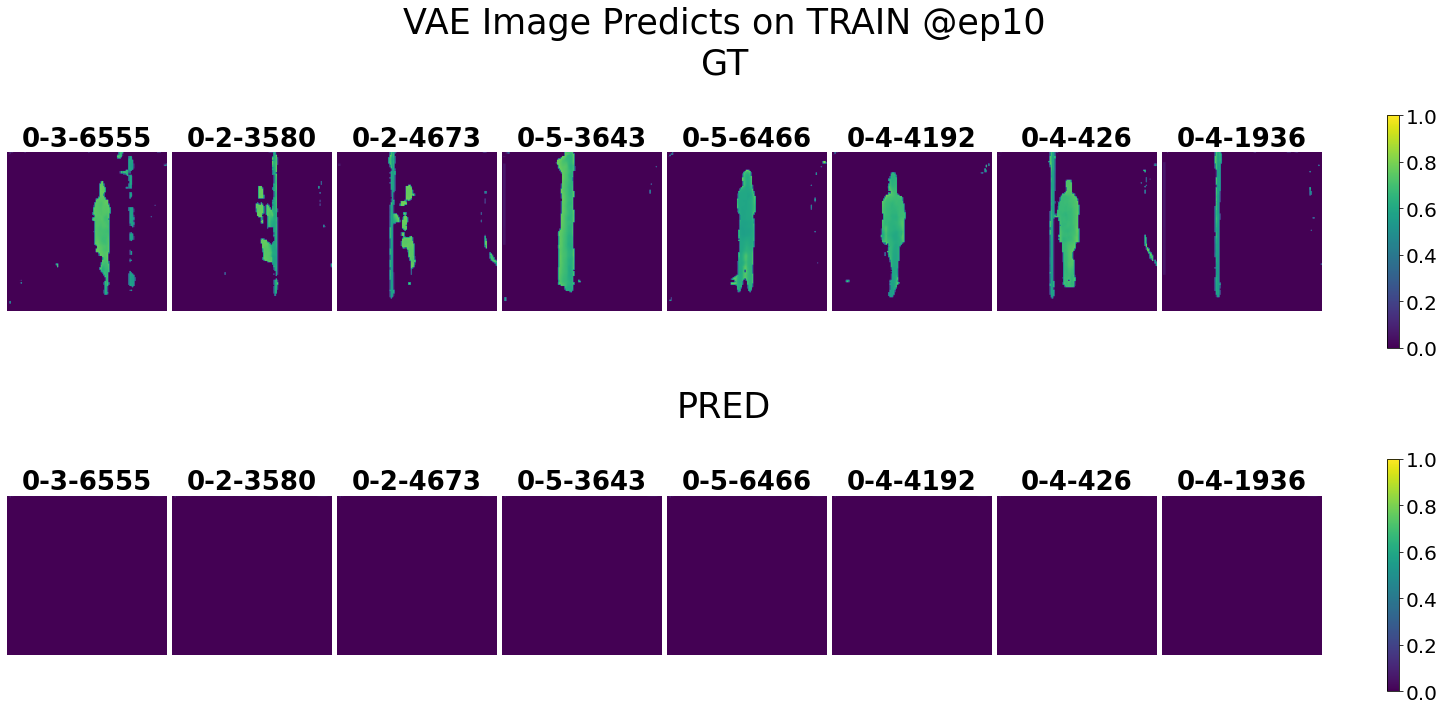

<Figure size 1440x720 with 0 Axes>

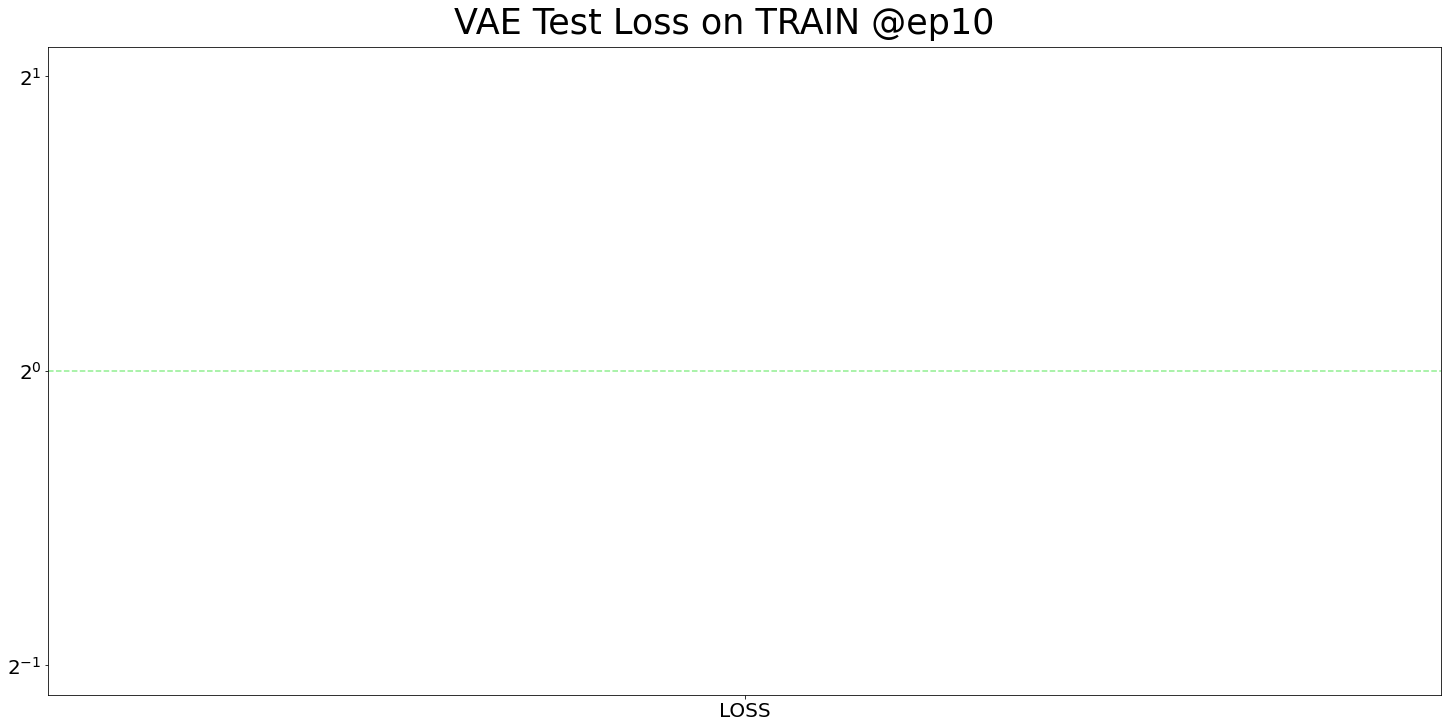

/home/bob/datastore/Models/Loss.py:234: RuntimeWarning: invalid value encountered in true_divide
  cdf = np.cumsum(hist / sum(hist))
/home/bob/datastore/Models/Loss.py:236: RuntimeWarning: invalid value encountered in true_divide
  axes[i].bar(bin_edges[1:], hist / max(hist), width=width, color='blue')


<Figure size 1440x720 with 0 Axes>

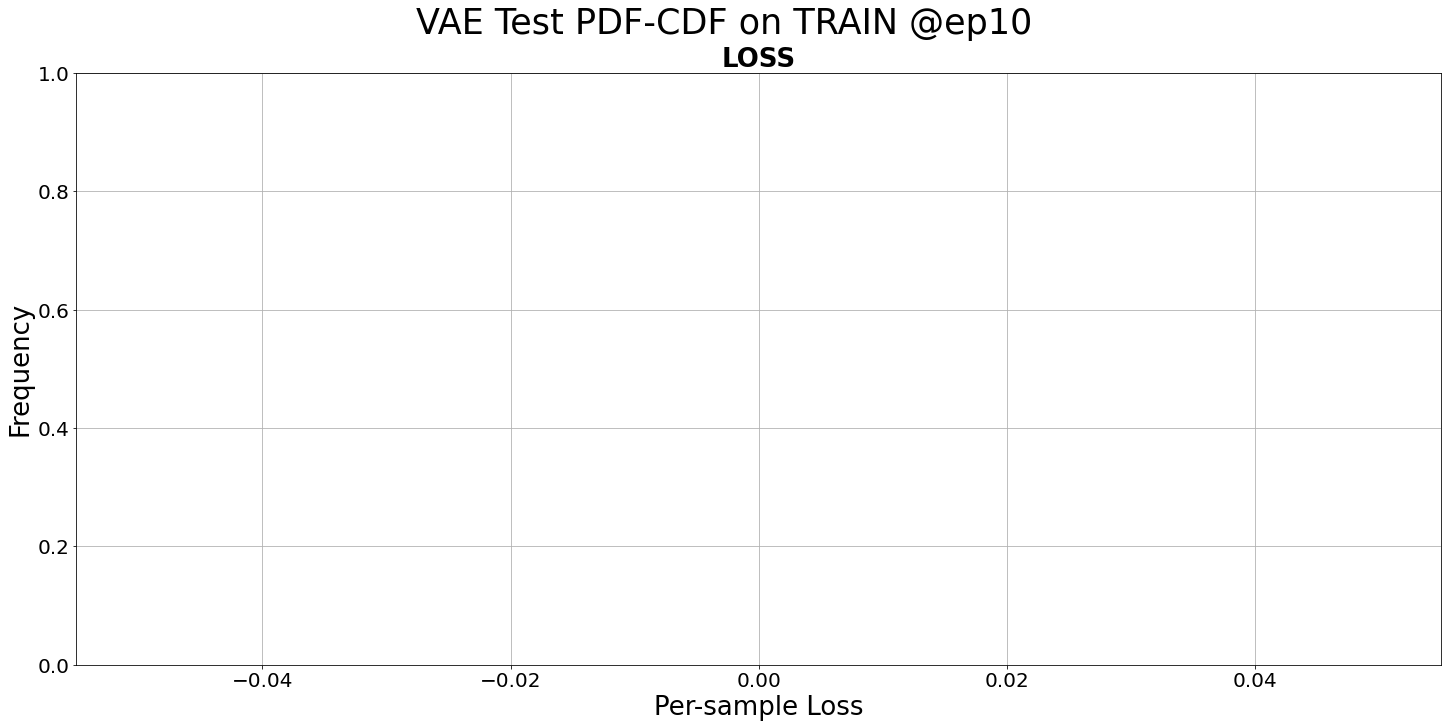

<Figure size 1440x720 with 0 Axes>

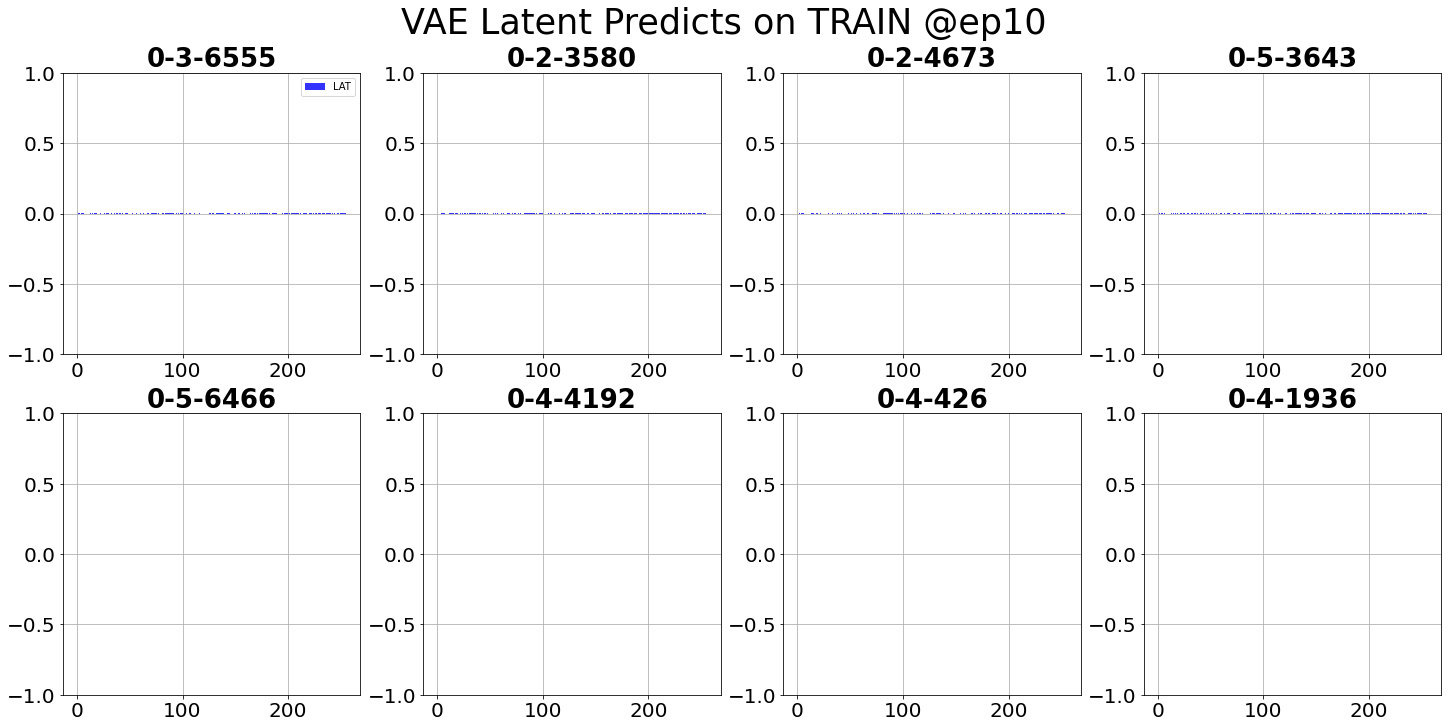

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

<Figure size 1440x720 with 0 Axes>

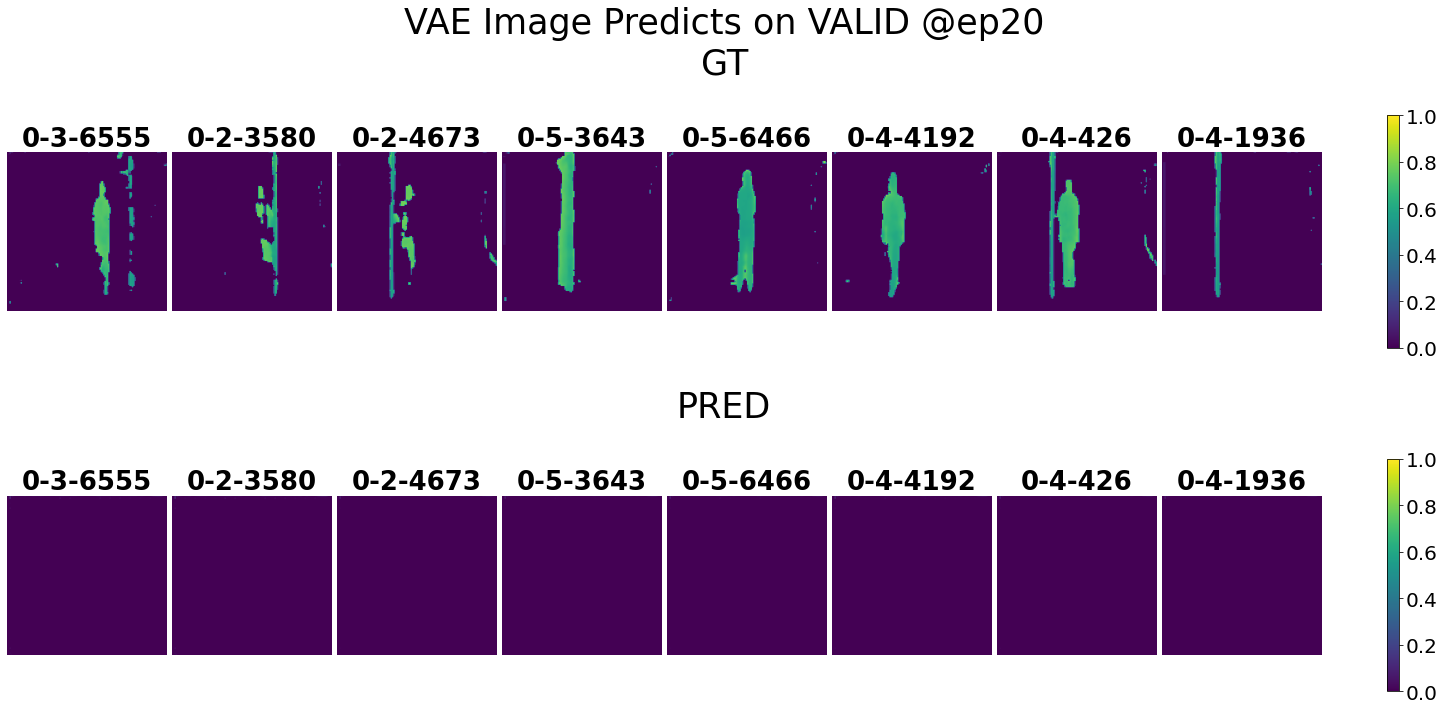

<Figure size 1440x720 with 0 Axes>

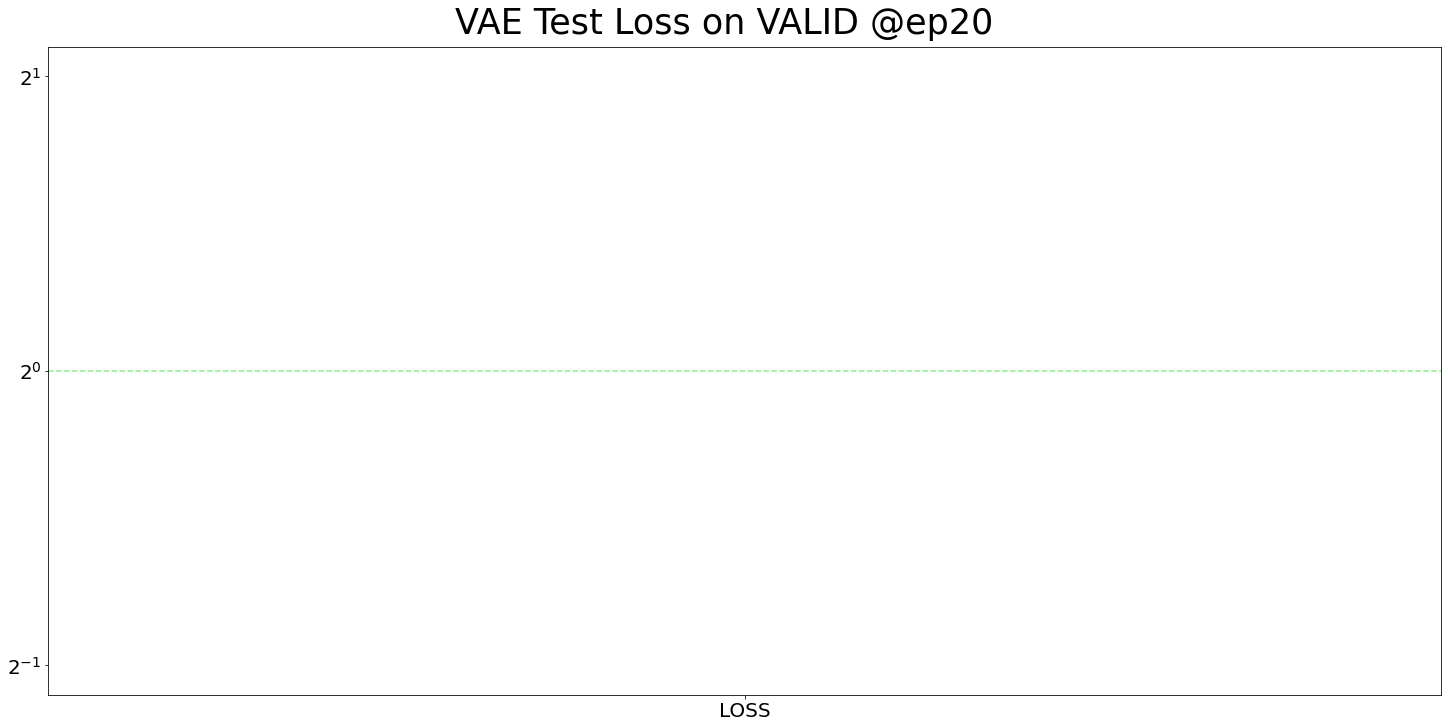

/home/bob/datastore/Models/Loss.py:234: RuntimeWarning: invalid value encountered in true_divide
  cdf = np.cumsum(hist / sum(hist))
/home/bob/datastore/Models/Loss.py:236: RuntimeWarning: invalid value encountered in true_divide
  axes[i].bar(bin_edges[1:], hist / max(hist), width=width, color='blue')


<Figure size 1440x720 with 0 Axes>

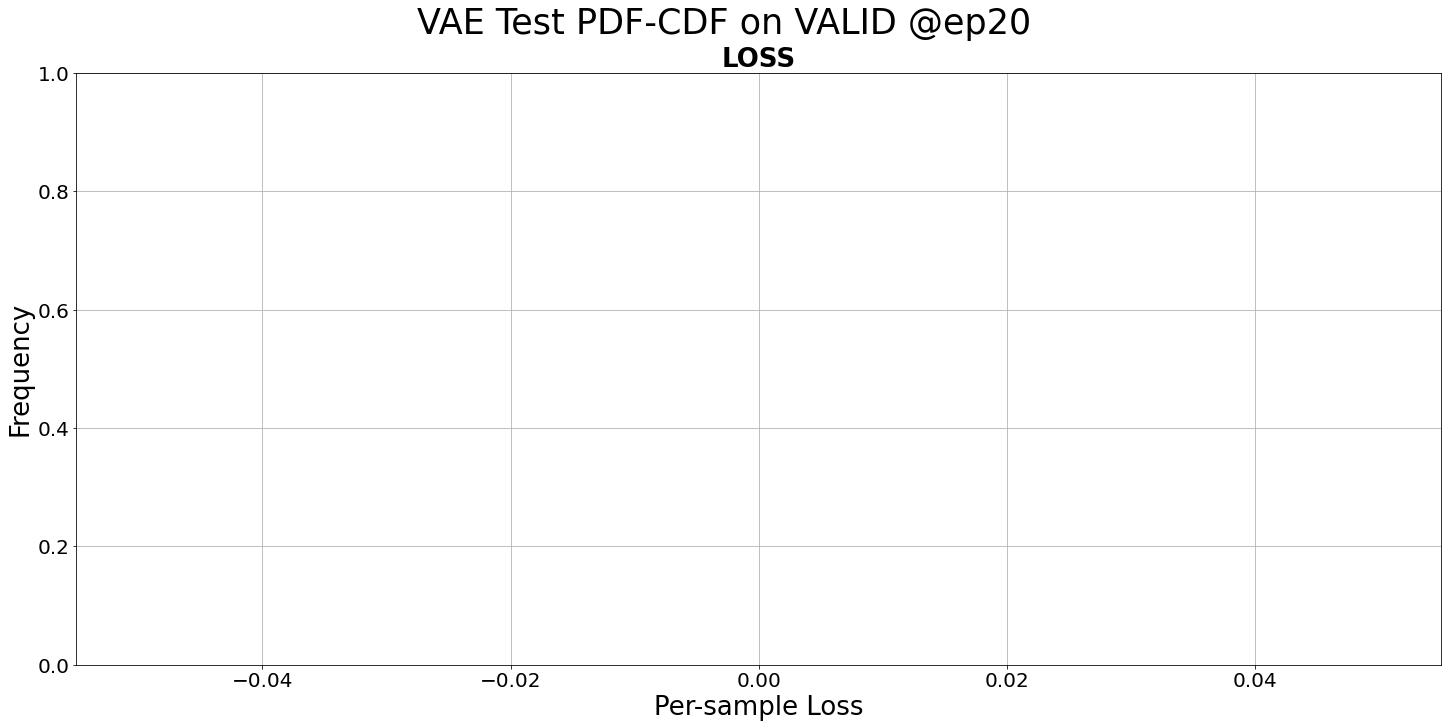

<Figure size 1440x720 with 0 Axes>

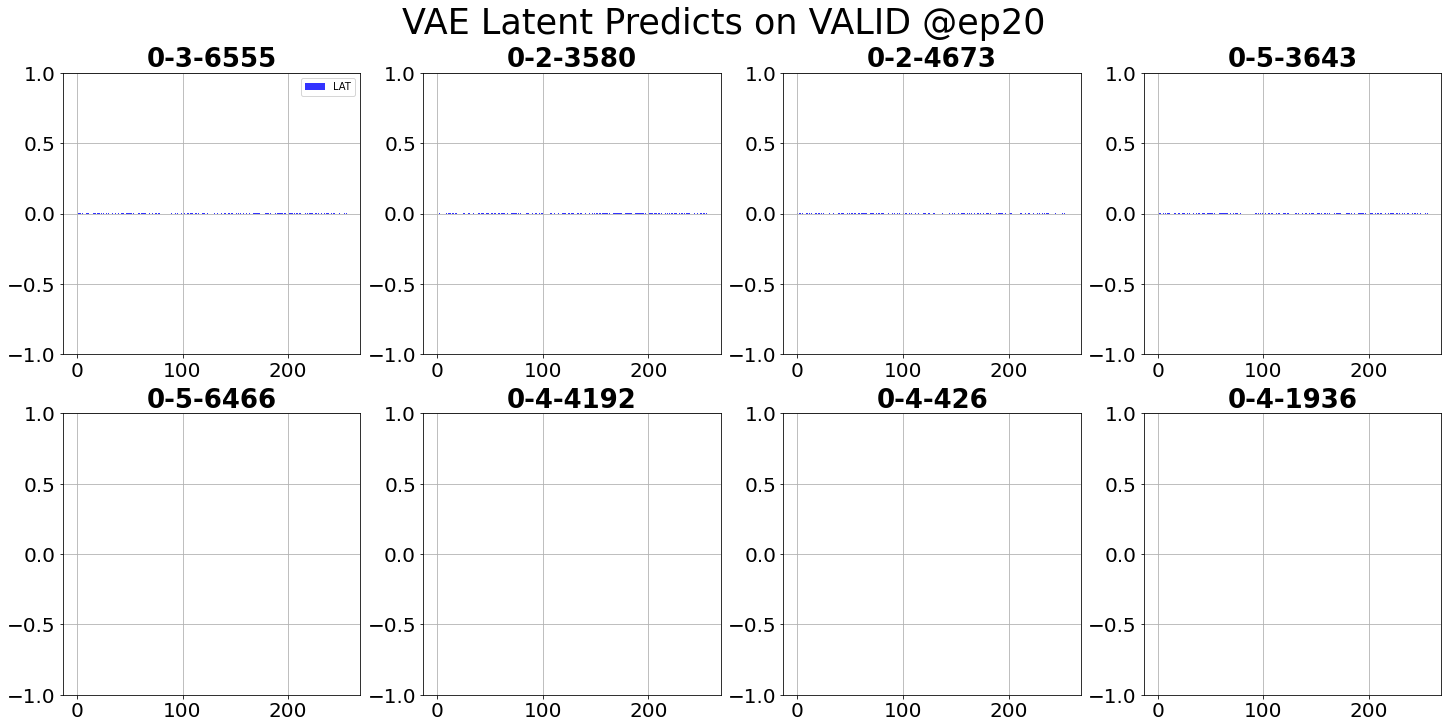

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

  0%|          |[00:00<?]

In [ ]:
gpu = 3
torch.cuda.set_device(gpu)
run()